In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
plt.style.use("customstyle")
import matplotlib.colors

import sys
sys.path.append("../modules")

import PBD_analog

colors = ["#" + x for x in ["000000","cf5c36","bcd696","985f99","9684a1"]]

In [5]:
# Load inference data
outdir = "C:/Users/pveron/Output_clusters/PBD_analog/12149"

simul_infer = pd.read_csv(outdir + "/all_simulations_inference.csv")
simul_infer["combinaison"] = 10*simul_infer.param_vary + simul_infer.i_param_var

summary_all_mcmc = pd.read_csv(outdir + "/summary_all_MCMC.csv")

n_rep = 1 + max(simul_infer.replicate)

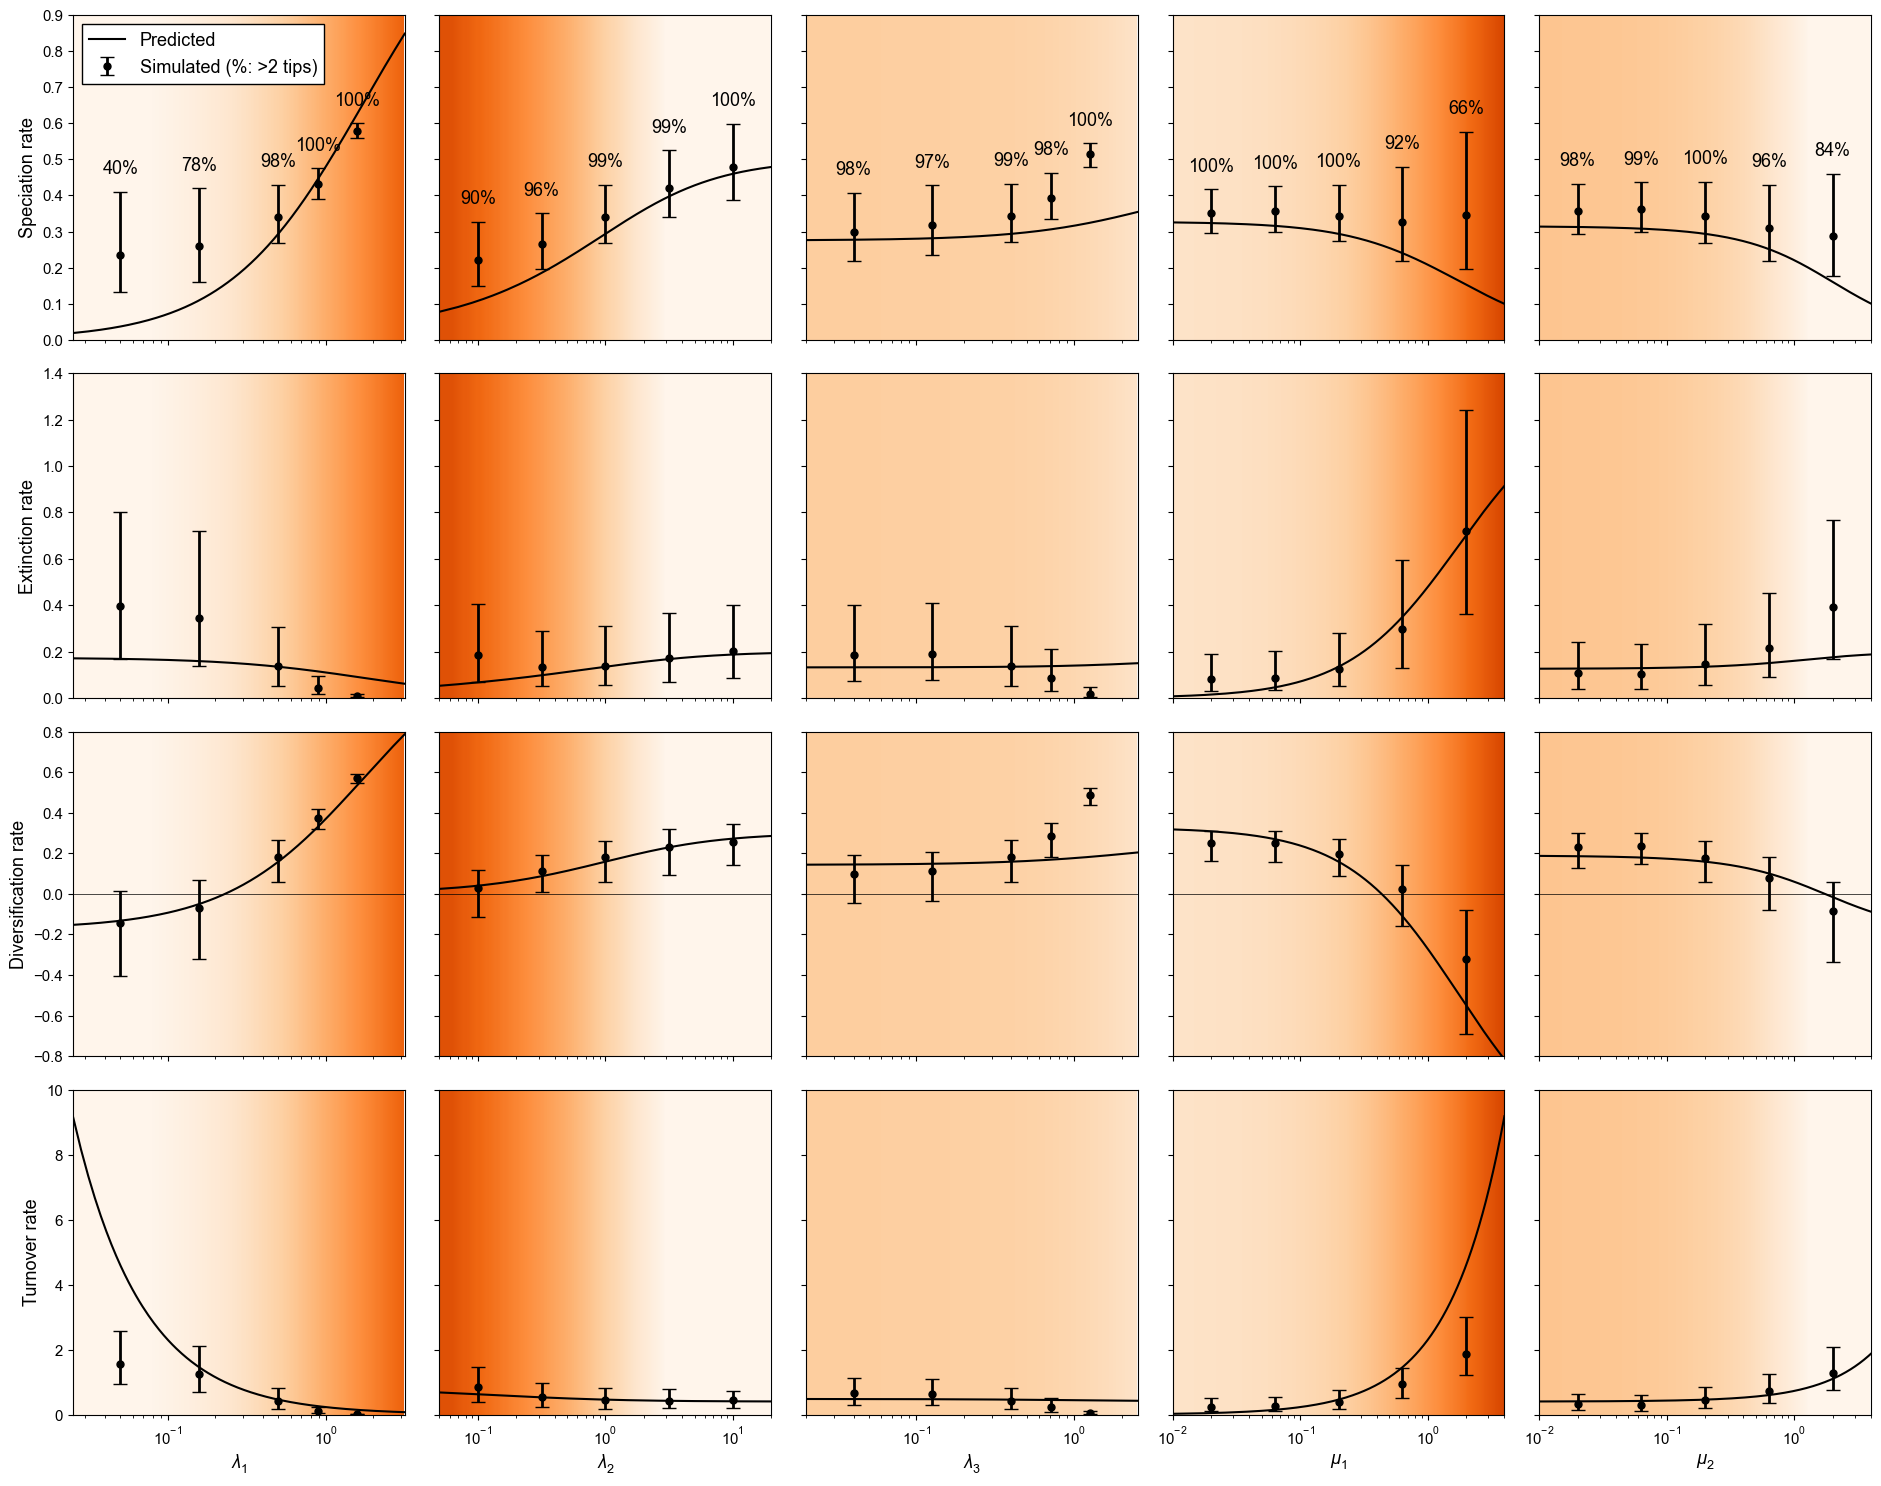

c:\Users\pveron\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


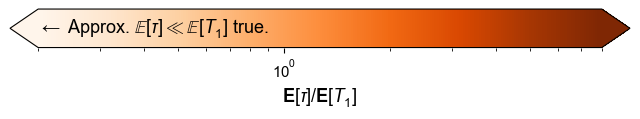

In [6]:
# Define ranges for the parameters 
ranges = {'l1':(0.025, np.power(10,0.5) * 2 * 0.5),
          'l2':(0.05, 20),
          'l3':(0.02, np.power(10.0,0.5) * 2 * 0.4),
          'm1':(0.01, 4),
          'm2':(0.01, 4)}

burnin = 500

param_default = {'l1':0.5, 'l2':1.0, 'l3':0.4, 'm1':0.2, 'm2':0.2}
par_names = list(param_default.keys())
par_names_PBD = ["PBD." + s for s in ['l1','l2','l3', 'mu1', 'mu2']]

rate_names = ["l", "mu", "div", "turnov"]

xlabels = ["$\\lambda_1$", "$\\lambda_2$", "$\\lambda_3$", "$\\mu_1$", "$\\mu_2$"]

# Style for the plot
stl = {"ls": "", "marker":"o", "elinewidth":2, "markersize" : 5, "capsize" : 5}
cmap = "Oranges"
logNorm = matplotlib.colors.LogNorm(0.2, 8)
fig, axes = plt.subplots(4,5, figsize = (19, 15), sharey="row", sharex="col")

for i in range(len(par_names)):
    par = par_names[i]
    param = param_default.copy()

    x = np.linspace(*ranges[par], 1000)
    # calculate predictions
    birth_pred, death_pred = np.zeros_like(x), np.zeros_like(x)
    T1, tau = np.zeros_like(x), np.zeros_like(x)    
    for j in range(len(x)):
        param[par] = x[j]
        birth_pred[j], death_pred[j] = PBD_analog.analog_BD_rates(**param)
        tau[j] = PBD_analog.tau(**param)
        T1[j] = PBD_analog.approx_expected_T(**param) - tau[j]

    
    im = np.array([tau / T1])

    axes[0,i].plot(x, birth_pred, color = colors[0], label = "Predicted")
    axes[1,i].plot(x, death_pred, color = colors[0])
    axes[2,i].plot(x, birth_pred - death_pred, color = colors[0])
    axes[3,i].plot(x, death_pred / birth_pred, color = colors[0])

    for j in range(4):
            extent = (x[0], x[-1], -10, 10)
            image = axes[j,i].imshow(im, cmap = cmap, norm = logNorm, 
                     aspect = 'auto', extent = extent)
    summary_par = summary_all_mcmc.loc[summary_all_mcmc.param_vary == i+1]


    # add text and errorbars
    for line in summary_par.index:
        axes[0,i].text(x = summary_par.loc[line, par_names_PBD[i]], 
                       y = summary_par.loc[line, "allMCMC.l.q75"] + 0.05,
                       s = "{:2.0f}%".format(summary_par.loc[line, "n_trees_MCMC"] / n_rep * 100), 
                       ha = "center")
    for k in range(4):
        r = rate_names[k]
        yerr = [summary_par["allMCMC."+r+".median"] - summary_par["allMCMC."+r+".q25"],
                summary_par["allMCMC."+r+".q75"] - summary_par["allMCMC."+r+".median"]]
        axes[k,i].errorbar(summary_par[par_names_PBD[i]], summary_par["allMCMC."+r+".median"], 
                           yerr = yerr, color = "k", label = "Simulated (%: >2 tips)", **stl)


    axes[-1,i].set_xlabel(xlabels[i])
    axes[0,i].set_xscale("log")

    for k in range(4):
        axes[k, i].axhline(0, ls = "-", lw = 0.5)


# Set manually the ylim
axes[0,0].set_ylim(0, 0.9) # speciation rate
axes[1,0].set_ylim(0, 1.4) # extinction rate
axes[2,0].set_ylim(-0.8, 0.8) # div rate
axes[3,0].set_ylim(0, 10)  # turnover rate 

fig_cb, ax_cb = plt.subplots(figsize = (8, 0.5))
plt.colorbar(image, orientation = 'horizontal', 
             label = "$\\mathbf{E}[\\tau] / \\mathbf{E}[T_1]$",
             extend = "both", cax = ax_cb)
ax_cb.text(0.2, 0.5, "$\\leftarrow$ Approx. $\\mathbb{E} [\\tau] \\ll \\mathbb{E} [T_1]$ true.", va = "center")
axes[0,0].legend()

axes[0,0].set_ylabel("Speciation rate")
axes[1,0].set_ylabel("Extinction rate")
axes[2,0].set_ylabel("Diversification rate")
axes[3,0].set_ylabel("Turnover rate");